<a href="https://colab.research.google.com/github/ThijsVercammen/Masterproef/blob/main/resnet50_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime
from datetime import datetime

%load_ext tensorboard

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['cats', 'dogs']
Number of train batches: 63
Number of validation batches: 26
Number of test batches: 6


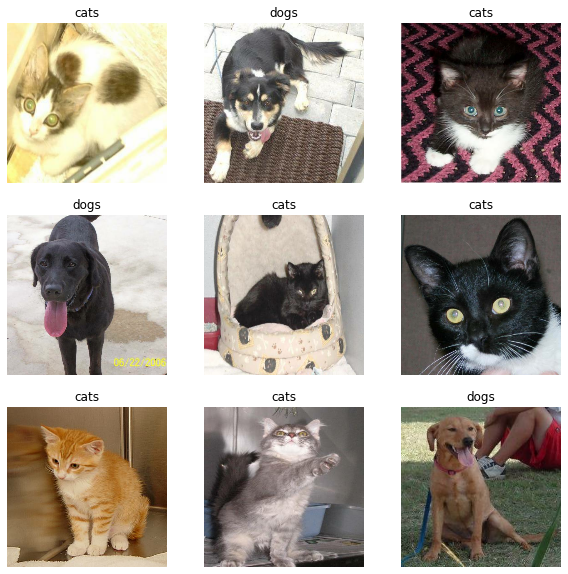

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#data_augmentation = tf.keras.Sequential([
#  tf.keras.layers.RandomFlip('horizontal'),
#  tf.keras.layers.RandomRotation(0.2),
#])

In [3]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
	input_shape=IMG_SHAPE)

base_model.summary()


image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [4]:
inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10

#loss0, accuracy0 = model.evaluate(validation_dataset)
#print("initial loss: {:.2f}".format(loss0))
#print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 238s 4s/step - loss: 0.2480 - accuracy: 0.9000 - val_loss: 0.0583 - val_accuracy: 0.9790
Epoch 2/10
63/63 [==============================] - 237s 4s/step - loss: 0.0775 - accuracy: 0.9665 - val_loss: 0.0543 - val_accuracy: 0.9827
Epoch 3/10
63/63 [==============================] - 236s 4s/step - loss: 0.0446 - accuracy: 0.9825 - val_loss: 0.0575 - val_accuracy: 0.9814
Epoch 4/10
63/63 [==============================] - 233s 4s/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 0.0570 - val_accuracy: 0.9802
Epoch 5/10
63/63 [==============================] - 233s 4s/step - loss: 0.0316 - accuracy: 0.9895 - val_loss: 0.0519 - val_accuracy: 0.9827
Epoch 6/10
63/63 [==============================] - 235s 4s/step - loss: 0.0288 - accuracy: 0.9875 - val_loss: 0.0535 - val_accuracy: 0.9802
Epoch 7/10
63/63 [==============================] - 235s 4s/step - loss: 0.0274 - accuracy: 0.9885 - val_loss: 0.0516 - val_accuracy: 0.9827
Epoch 8/10
63

6/6 [==============================] - 16s 3s/step - loss: 0.0464 - accuracy: 0.9792
Test accuracy : 0.9791666865348816
Predictions:
 [1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1
 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1]
Labels:
 [0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1]


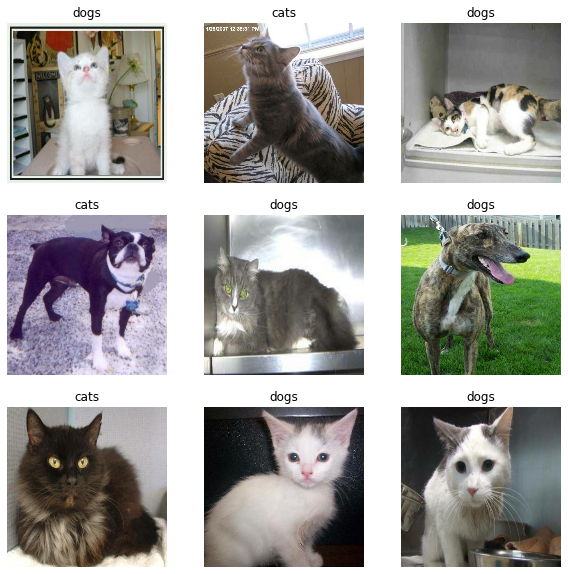

In [5]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
from PIL import Image

im = Image.open("./d_2.jfif")
res_im = im.resize((160, 160))
np_res_im = np.array(res_im, dtype=np.float32)

now = datetime.now()

img_array = tf.expand_dims(np_res_im, 0) # Create a batch
predictions = model.predict(img_array)#.flatten()
score = tf.nn.softmax(predictions)
print(score)
print(tf.reduce_max(score))
print(datetime.now()-now)

#predictions = tf.where(tf.reduce_max(score) < 0.5, 0, 1)

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)

tf.Tensor([[1.0118694e-05 9.9998987e-01]], shape=(1, 2), dtype=float32)
tf.Tensor(0.99998987, shape=(), dtype=float32)
0:00:00.071883
This image most likely belongs to dogs.


In [17]:

model.save('model_k.h5')
from google.colab import files
files.download('model_k.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from tensorflow.keras import activations

model.save('./model')
#probability_model = tf.keras.Sequential([model, tf.keras.layers.Activation(activations.sigmoid)])
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
#probability_model.build([None, 224, 224, 3])
converter = tf.lite.TFLiteConverter.from_keras_model(probability_model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]

#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)



INFO:tensorflow:Assets written to: ./model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /tmp/tmprjjuzz3a/assets


93989756

In [11]:
from PIL import Image
import pandas as pd

im = Image.open("d_1.jfif")
interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()
det = interpreter.get_signature_list()
print(det)
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

now = datetime.now()

res_im = im.resize((100, 100))
now = datetime.now()

input_data = np.asarray(res_im, dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], [input_data])
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print(datetime.now()-now)

print(class_names[np.argmax(output_data)])

{'serving_default': {'inputs': ['model_input'], 'outputs': ['softmax']}}


ValueError: ignored

In [ ]:
interpreter.get_tensor_details()

In [14]:
!pip install tflite-support
!pip install onnxruntime
!pip install -U tf2onnx
!pip install git+https://github.com/onnx/tensorflow-onnx
!pip install onnxruntime
!pip install onnx2pytorch



  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-q1oxkjiy
  Running command git clone -q https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-q1oxkjiy


In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "./model.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "./labels.txt"
_SAVE_TO_PATH = "./model_meta.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 0.0
_INPUT_NORM_STD = 1.0

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  0.0
                ],
                "std": [
                  1.0
                ]
              }
            }
          ],
          "stats": {
            "max": [
              255.0
            ],
            "min": [
              0.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probabil

In [ ]:
from tensorflow.core.protobuf.saved_model_pb2 import SavedModel

saved_model = SavedModel()
with open('model/saved_model.pb', 'rb') as f:
    saved_model.ParseFromString(f.read())
model_op_names = set()
# Iterate over every metagraph in case there is more than one
for meta_graph in saved_model.meta_graphs:
    # Add operations in the graph definition
    model_op_names.update(node.op for node in meta_graph.graph_def.node)
    # Go through the functions in the graph definition
    for func in meta_graph.graph_def.library.function:
        # Add operations in each function
        model_op_names.update(node.op for node in func.node_def)
# Convert to list, sorted if you want
model_op_names = sorted(model_op_names)
print(*model_op_names, sep='\n')

AddV2
AssignVariableOp
BiasAdd
Cast
Const
Conv2D
FusedBatchNormV3
GreaterEqual
Identity
MatMul
MaxPool
Mean
MergeV2Checkpoints
Mul
NoOp
Pack
Pad
PartitionedCall
Placeholder
RandomUniform
ReadVariableOp
Relu
RestoreV2
SaveV2
Select
Shape
ShardedFilename
StatefulPartitionedCall
StaticRegexFullMatch
StridedSlice
StringJoin
VarHandleOp


In [18]:
!python -m tf2onnx.convert --tflite ./model.tflite --output model_lite.onnx


/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-11-24 14:19:52,278 - INFO - Using tensorflow=2.7.0, onnx=1.10.2, tf2onnx=1.10.0/d018aa
2021-11-24 14:19:52,278 - INFO - Using opset <onnx, 9>
2021-11-24 14:19:52,927 - ERROR - Failed to convert node 'sequential/model/tf.__operators__.getitem/strided_slice2' (fct=<bound method StridedSlice.version_1 of <class 'tf2onnx.onnx_opset.tensor.StridedSlice'>>)
'OP=StridedSlice\nName=sequential/model/tf.__operators__.getitem/strided_slice2\nInputs:\n\tserving_default_model_input:0=Placeholder, [-1, 160, 160, 3], 1\n\tsequential/model/tf.__operators__.getitem/strided_slice=Const, [4], 6\n\tsequential/model/tf.__operators__.getitem/strided_slice=Const, [4], 6\n\tsequential/model/tf.__operators__.getitem/strided_slice1=Const, [4], 6\nOutpus:\n\tsequential/mod

In [ ]:
!python -m tf2onnx.convert --saved-model ./model --output model.onnx --opset 10
from google.colab import files
files.download('mnist.tflite')

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-11-23 19:05:12,711 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2021-11-23 19:05:22,666 - INFO - Signatures found in model: [serving_default].
2021-11-23 19:05:22,666 - WARNING - '--signature_def' not specified, using first signature: serving_default
2021-11-23 19:05:22,668 - INFO - Output names: ['dense']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-11-23 19:05:25,806 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-11-23 19:05:27,069 - INFO - Using tenso

In [ ]:
!python -m onnxruntime.tools.convert_onnx_models_to_ort ./model.onnx

Converting optimized ONNX model /content/model.onnx to ORT format model /content/model.all.ort
Converted 1 models. 0 failures.
2021-11-23 15:54:28,555 ort_format_model.utils [INFO] - Processed /content/model.all.ort
2021-11-23 15:54:28,558 ort_format_model.utils [INFO] - Created config in /content/model.all.required_operators.config


In [ ]:
!python -m onnxruntime.tools.convert_onnx_models_to_ort ./model_lite.onnx

Converting optimized ONNX model /content/model_lite.onnx to ORT format model /content/model_lite.all.ort
Converted 1 models. 0 failures.
2021-11-23 15:54:36,759 ort_format_model.utils [INFO] - Processed /content/model_lite.all.ort
2021-11-23 15:54:36,763 ort_format_model.utils [INFO] - Created config in /content/model_lite.all.required_operators.config


In [ ]:
import onnx
import torch

from onnx2pytorch import ConvertModel
from torchvision.transforms import transforms
from torch.autograd import Variable



onnx_model = onnx.load("./model_lite.onnx")
pytorch_model = ConvertModel(onnx_model)
pytorch_model.eval()
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)
    image = image.resize((160, 160))
    image = np.asarray(image, dtype=np.float32)
    x_np = torch.from_numpy(image)

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = x_np.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Turn the input into a Variable
    input = Variable(image_tensor)

    # Predict the class of the image
    output = pytorch_model(input)
    print(output[0])
    #a = torch.nn.Sigmoid()
    #print(a(output))
    index = output[0][0]#output.data.numpy().argmax()

    return index

index = predict_image("c_1.jfif")

#print(class_names[int(output_data[0][0])])

Prediction in progress
tensor([-0.6115,  0.5809], grad_fn=<SelectBackward0>)
